# Multicollinearity ve Correlation Hakkında Yanlış Bilinenler

## Hazırlayan: https://github.com/Frightera

In [1]:
import numpy as np
import pandas as pd
import shap

import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import cm as colormap
from matplotlib import colors

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler as Scaler

from sklearn.metrics import f1_score

import statsmodels.api as sm
from lazypredict.Supervised import LazyClassifier
from xgboost import XGBClassifier

from mlxtend.plotting import plot_decision_regions
from statsmodels.stats.outliers_influence import variance_inflation_factor

np.random.seed(42)

n_samples = 1000

## Korelasyon (Correlation) Nedir?
Korelasyon (correlation), iki değişken arasındaki ilişkinin gücünü ölçen bir istatistiksel terimdir.

Burada dikkat edilmesi gereken nokta, bu ilişki **LINEER** veya **NON-LINEER** olabilir. Veri Biliminde çoğu kez pandas dataframelerinde `corr()` methodu kullanılıp yanlış adımlar uygulanmaktadır. Detayına ilerleyen bölümlerde değineceğim.

### Yanlış Adımlar derken...
* Birbiri ile correlation gösteren özelliklerin (multicollinearity) hemen drop edilmesi
* Hedef değişken ile correlation gösteren özelliklerin drop edilmesi

Correlation, aksi belirtilmedikçe lineer olarak ifade edilmektedir. Birbiri ile correlation içeren featurelar sadece bazı ML modelleri için zararlıdır (nasıl zararlı olduğuna değiniyor olacağız) ve her model bundan etkilenmez.

### Etkilenen Modeller
* **Linear Regression**
* **Logistic Regression**
...

### Etkilenmeyen Modeller
* **Ağaç Tabanlı Modeller**
* **Deep Learning Modelleri**
...

## Correlation Overfit Yapar Mı?

### Featurelar Arası Correlation (Multicollinearity)
* **Cevap:** HAYIR
  * Açıklama: Test veya production ortamında da aynı şekilde veriler geleceğini varsaydığımız için tahminlerimiz doğru çıkacaktır. Test verisi değişmeye başlarsa (data drift) zaten model de kötü performans gösterecektir.

### Feature - Label Arası Correlation
* **Cevap:** HAYIR
  * Açıklama: Hedef değişken ile correlation içeren özellikler, modelin işini kolaylaştırır. Diyelim ki ekstrem bir durum oldu, `0.9` correlation içeren bir özellik var. Yine overfitting ile alakalı bir şey söylenemez, çünkü yeni gelecek veriler de bu correlation'ı içeriyorsa model doğru tahminler yapmaya devam edecektir. 
  
## Multicollinearity, yorumlamayı zorlaştırır.
* Bunu örneklerle açıklıyor olacağız. Basitçe giriş yaptığımıza göre ilerleyebiliriz.

--- 

## İçindekiler

* ### Classification Verisetinin Oluşturulması

* ### Correlation Heatmap İncelenmesi

* ### LazyPredict ile İyi Modeli Seçmek

* ### XGBoost ile Deneyler

* ### Logistic Regression ile Deneyler
 * #### Variance Inflation Factor

## Verisetinin Oluşturulması

In [2]:
# Sklearn ile sınıflandırma veriseti oluşturma
X, y = make_classification(n_samples=n_samples,
                           n_features=7,
                           n_redundant=0,
                           n_clusters_per_class=2,
                           n_informative=2,
                           random_state=42,
                           shift=2.5,
                           scale=2,)

# Diğer özelliklerle ilişkili yeni özellikler türetmek.
# Lineer ilişki
x8 = X[:, 0] * 1.5 + np.random.normal(0, 0.5, n_samples)
x9 = X[:, 2] * 2 + np.random.normal(1, 0.2, n_samples)

# Lineer olmayan ilişki
x10 = np.sin(X[:, 0] ** 2) + np.random.normal(0, 0.1, n_samples)
x11 = np.cos(X[:, 1] ** 2) + np.random.normal(0, 0.1, n_samples)

# Diğer özellikleri eklemek
X_all = np.column_stack((X, x8, x9, x10, x11))

column_names = [f'x{i+1}' for i in range(X_all.shape[1])]
data = pd.DataFrame(X_all, columns=column_names)
data['labels'] = y

# Karıştıralım
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# Bir şekilde NaN varsa uğraşmaya gerek yok.
data.dropna(inplace=True)
data

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,labels
0,3.85,7.05,4.23,4.73,4.62,5.09,4.71,6.05,9.57,1.06,0.56,0
1,4.23,10.28,7.33,7.04,5.60,4.28,3.86,6.83,15.44,-0.80,0.33,1
2,4.51,8.13,0.94,2.39,4.45,3.15,1.59,5.85,2.86,1.04,-1.07,0
3,1.71,3.34,-0.24,2.05,4.79,1.80,7.98,2.28,0.79,0.09,0.14,0
4,5.40,6.22,3.15,7.20,1.89,4.56,2.64,7.54,7.41,-0.63,0.52,0
...,...,...,...,...,...,...,...,...,...,...,...,...
995,6.43,6.46,4.13,3.91,6.08,7.51,2.53,10.59,9.38,-0.59,-0.74,0
996,4.18,3.81,9.90,2.12,0.22,7.46,5.76,6.98,21.02,-0.95,-0.36,1
997,8.22,6.96,4.63,6.42,2.26,3.58,3.77,12.43,10.24,-1.05,-0.33,1
998,4.64,6.85,2.04,7.38,4.82,2.62,5.07,7.00,5.14,0.37,-0.90,0


In [3]:
# Dengeli veriseti
print(data.labels.value_counts(normalize=True) * 100)

0   50.00
1   50.00
Name: labels, dtype: float64


In [4]:
def plot_corr(data: pd.DataFrame,
              title: str,
              figsize: tuple = (14, 10)) -> None:
    """
    Verilen dataframe'in correlation heatmapini çizdirir.
    Args:
        data (pd.DataFrame): Hedef dataframe.
        title (str): Plot başlığı.
        figsize (tuple): Plot boyutu.
    """
    # Correlation matrisini oluştur.
    corr = data.corr()

    # Üst üçgen matristeki değerleri maskele
    mask = np.zeros_like(corr, dtype=np.bool_)
    mask[np.triu_indices_from(mask)] = True

    # Heatmapi plot et
    plt.figure(figsize=figsize)
    sns.heatmap(corr,
                annot=True,
                fmt = ".2f",
                mask=mask, # üst üçgen matrisi plottan dışarı atabiliriz
                annot_kws={"size": 16, "font": "arial", "fontweight": "bold"},
                linewidths=1.8,
                linecolor='black')
    
    # colorbarın fontsize'ını artır
    cbar = plt.gcf().axes[-1]
    cbar.tick_params(labelsize=14)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14, rotation=0)
    plt.title(title, fontsize=16)
    plt.show()

In [5]:
def plot_decision_boundary(model,
                           X_train, y_train,
                           X_test, y_test,
                           plot_test=True,
                           figsize=(17, 11)):
    """
    Plot the decision boundary of a given model.
    Args:
        model (sklearn model): The model to plot.
        X_train (np.array): The training features.
        y_train (np.array): The training labels.
        X_test (np.array): The test features.
        y_test (np.array): The test labels.
        title (str): The title of the plot.
        figsize (tuple): The size of the plot.
    """

    def plot_decision_subplot(X, y, subplot_id, title):
        plt.subplot(1, 2, subplot_id)
        plot_decision_regions(X, y,
                              clf=model, legend=4,
                              scatter_kwargs={'s': 100, 'linewidths': 1, 'edgecolors': 'blue'},
                              zoom_factor=2,
                              markers=['o', 's'])
        plt.title(title, fontsize=16)

    plt.subplots(figsize=figsize)

    # Plot the training set and test set next to each other
    plot_decision_subplot(X_train, y_train, 1, 'Training Set')
    if plot_test:
        plot_decision_subplot(X_test, y_test, 2, 'Test Set')

    plt.show() 

### Correlation İnceleyelim
* `x8` ve `x9` sırasıyla `x1` ve `x3`'ten lineer bir şekilde türetildiği için `data.corr()` yapınca çok yüksek ilişki görüyoruz.



* `x10` ve `x11` sırasıyla `x1` ve `x2`'den lineer olmayan fonksiyonlar kullanılıp türetildiği için `data.corr()`'da yüksek değerler görmüyoruz.



* Bu, ilişkilerin illa lineer olacağı yargısını çürütmüş oluyor. `data.corr()`, `Pearson` correlation kullanıyor, yani bu method lineer olmayan ilişkileri göstermek için uygun değil. Çoğu zaman bu göz ardı ediliyor ve correlation olmaması iyi şeklinde yorumlar yapılıyor. Correlation non-lineer de olabilir.

#### Correlation Olmaması İyi Ne Demek!?
 * Demek istediğim şuydu, özelliklerimiz arasında correlation olmasın, hatta bu yorum verilerimiz arasında ilişki güçlü olmasın'a kadar gidiyor. Bu yanlış bir yorumdur. Özellikler ve hedef arasında bir ilişki olmazsa veriseti öğrenilemez.


#### Lineer Modeller Kullanırken Bu Şekilde Non-Lineer İlişkiler Olması Nasıl Etkiler?
* Birazcık karmaşık bir konu, farklı farklı edge case'ler olabilir. Kısaca modele o şekilde verip performansın iyi olduğundan eminsek, olduğu gibi bırakabiliriz. Fakat model, bu non-lineer özelliklerin değişikliklerden daha çabuk etkilenebilir **(kişisel tecrübe)**. Modellerin türüne göre bu değişebilir, DL modelleri (non-lineer modellerdir) over-parameterizated olduğu için bundan kolay kolay etkilenmezler

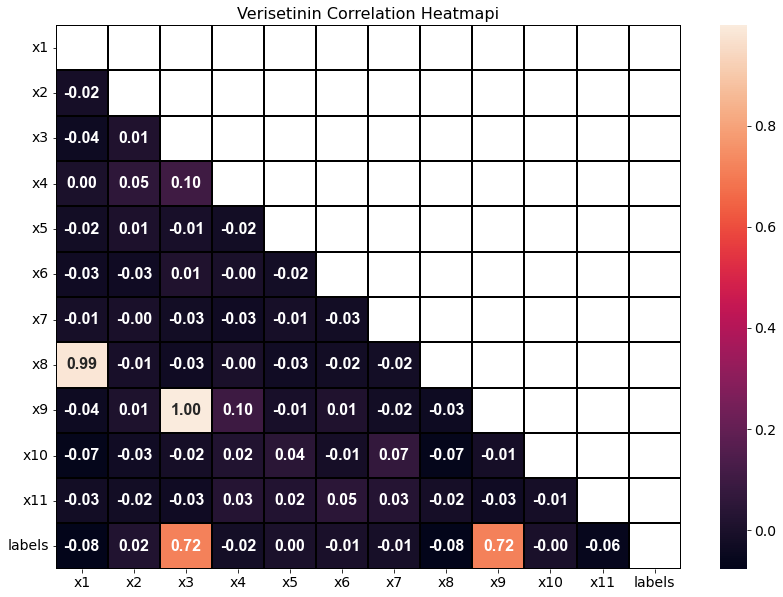

In [6]:
plot_corr(data, 'Verisetinin Correlation Heatmapi')

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('labels', axis=1),
                                                    data['labels'],
                                                    test_size=0.2,
                                                    random_state=42)
# Trainde fit_transform
# Test için sadece transform!!!
scaler = Scaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=column_names)
X_test = pd.DataFrame(X_test, columns=column_names)

X_train

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11
0,0.66,0.69,0.55,0.39,0.68,0.57,0.52,0.64,0.55,0.80,0.62
1,0.06,0.29,0.42,0.60,0.17,0.52,0.04,0.10,0.42,0.70,0.95
2,0.53,0.28,0.38,0.66,0.38,0.19,0.56,0.44,0.39,0.98,0.83
3,0.61,0.51,0.47,0.43,0.52,0.62,0.64,0.59,0.47,0.34,0.14
4,0.61,0.60,0.46,0.70,0.60,0.20,0.31,0.60,0.46,0.56,0.14
...,...,...,...,...,...,...,...,...,...,...,...
795,0.53,0.64,0.22,0.32,0.30,0.59,0.41,0.53,0.22,0.82,0.03
796,0.40,0.28,0.65,0.66,0.58,1.00,0.59,0.40,0.65,0.63,0.86
797,0.58,0.54,0.81,0.30,0.52,0.25,0.39,0.63,0.81,0.88,0.70
798,0.49,0.17,0.44,0.42,0.32,0.45,0.62,0.49,0.45,0.71,0.59


100%|██████████| 29/29 [00:01<00:00, 18.56it/s]


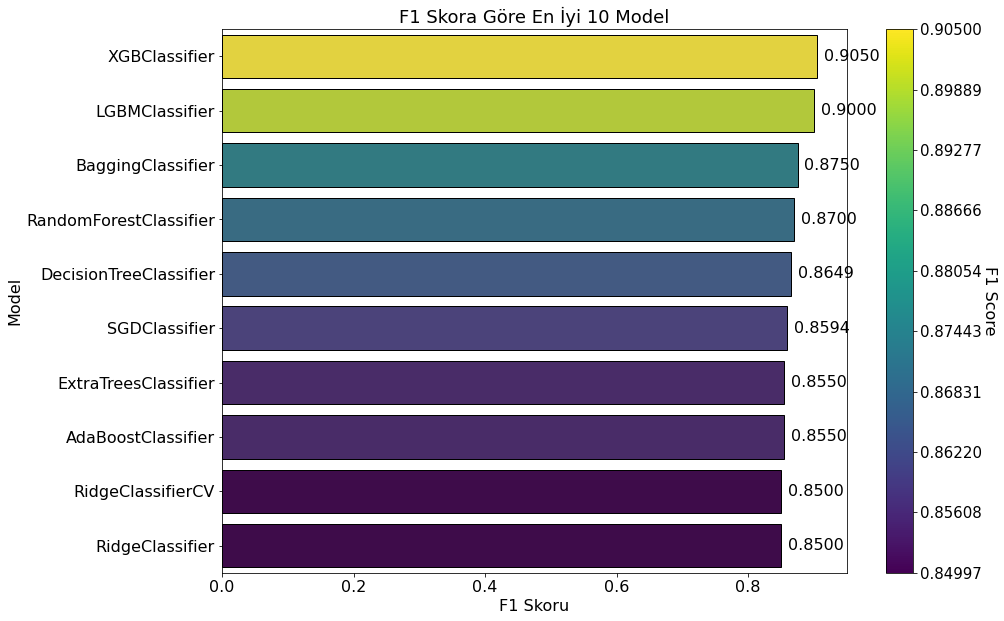

In [8]:
# Bilinen çoğu modelin performansını görmek için LazyPredict
# kütüphanesinden LazyClassifier kullanacağız. Bu bizim için
# modelleri fit edip, test verisi üzerindeki performansı döndürecek.
clf = LazyClassifier(verbose=0, ignore_warnings=True, random_state=1002)

models, predictions = clf.fit(X_train, X_test, y_train, y_test)

# Sonuçlarda F1-Skoru yer alıyor, en büyükten küçüğe doğru sıralayıp ilk
# 10 modeli alalım.
sorted_models = models.sort_values(by='F1 Score', ascending=False).head(10)

# Değerler için colormap oluşturalım.
cmap = colormap.viridis

# F1-Skorlarını colormap sınırları içinde olacak şekilde
# normalize edelim
norm = colors.Normalize(vmin=sorted_models['F1 Score'].min(),
                        vmax=sorted_models['F1 Score'].max())

# Yatay bir barplot oluşturmak için seaborn kullanalım.
# orient='h' kısmı yataylığı belirtiyor.
plt.figure(figsize=(14, 10))
ax = sns.barplot(x='F1 Score',
                 y=sorted_models.index,
                 data=sorted_models, 
                 palette=cmap(norm(sorted_models['F1 Score'])),
                 orient='h',
                 edgecolor='black')
ax.tick_params(axis='y', labelsize=16)
ax.tick_params(axis='x', labelsize=16)

# Barların üstüne F1 Skorlarını yazmak için dönelim
for i, p in enumerate(ax.patches):
    ax.annotate(f"{sorted_models.iloc[i]['F1 Score']:.4f}", 
                (p.get_width() + 0.01, 
                 p.get_y() + p.get_height() / 2),
                ha='left', va='center', fontsize=16, color='black')

plt.title('F1 Skora Göre En İyi 10 Model', fontsize=18)
plt.xlabel('F1 Skoru', fontsize=16)
plt.ylabel('Model', fontsize=16)

# Sağ tarafa colorbar ekle
smap = colormap.ScalarMappable(cmap=cmap, norm=norm)
smap.set_array([])
cbar = plt.colorbar(smap, ticks=np.linspace(sorted_models['F1 Score'].min(), 
                                            sorted_models['F1 Score'].max(), 10))
cbar.ax.tick_params(labelsize=15)
cbar.set_label('F1 Score', rotation=270, labelpad=15, **{'fontsize': 16})

plt.show()

### SHAP ve Feature Importance Değerlerine Bakılması
**SHAP:** SHAP değerleri, her özelliğin modelin tahmininine ne kadar katkı yaptığını gösterir. Yapılan tahminler yanlış olduğu takdirde SHAP değerlerinin toplamı ile hedef değerler eşleşmez.

**XGBoost Feature Importances (Gain):** Her ağaçtaki information gain'in ortalamasının alınmış halidir. Information gain ise, her ağaçta bulunan nodeların en iyi şekilde split edilmesini sağlayan bir metriktir. Yani splitlerin kalitesini ölçer şeklinde düşünebilirsiniz. Bu şekilde tahminlerin, hedef değerlere daha yakın olması sağlanır. Diğer bir deyişle, `train setini genelleyebilmek için hangi özellikler daha çok kullanıldı?` sorusunun cevabını arar.

In [9]:
# XGBoost en iyi çıktığı için onunla devam edelim.
# Sonucu iyileştirebilecek parametreler ile deniyorum.
# Burada daha fazla tuning yapılabilir fakat amacımız
# modelin performansını maksimize etmek değil. Bu parametrelerin
# şuanki veride iyi çalışacağını düşündüğüm için bu şekilde
# verdim

xgb_params = {
    'random_state': 42,
    'n_estimators': 500,
    'max_depth': 5,
    'learning_rate': 0.001,
    'gamma': 0.2,
    'min_child_weight': 2,
    'subsample': 0.9,
    'colsample_bytree': 0.9
}

xgb = XGBClassifier(**xgb_params)
xgb.fit(X_train, y_train)

print(f'Train setinde F1: {f1_score(y_train, xgb.predict(X_train)):.4f}')
print(f'Test setinde F1: {f1_score(y_test, xgb.predict(X_test)):.4f}')

# Feature Importance bakalım.
feature_importance = pd.DataFrame({'feature': X_train.columns, 
                                   'importance': list(xgb.get_booster().get_score(importance_type='gain').values())})
feature_importance.sort_values('importance', ascending=False, inplace=True, ignore_index=True)
feature_importance

Train setinde F1: 0.9439
Test setinde F1: 0.9254


,feature,importance
0,x9,85.50
1,x3,58.09
2,x4,9.88
3,x2,4.68
4,x11,4.27
5,x6,3.05
6,x10,2.83
7,x7,2.76
8,x8,2.74
9,x1,2.13


#### Beklenildiği üzere x9 ve x3 daha yüksek çıktı fakat burada overfitting olmuştur denemez. Overfitting'in nasıl olduğunu biraz sonra decision boundary'e bakarak gözlemleyeceğiz.
 * `X3` ve `X9` hedef ile yüksek correlation katsayısına sahip.

#### Shap Değerlerine bakalım.

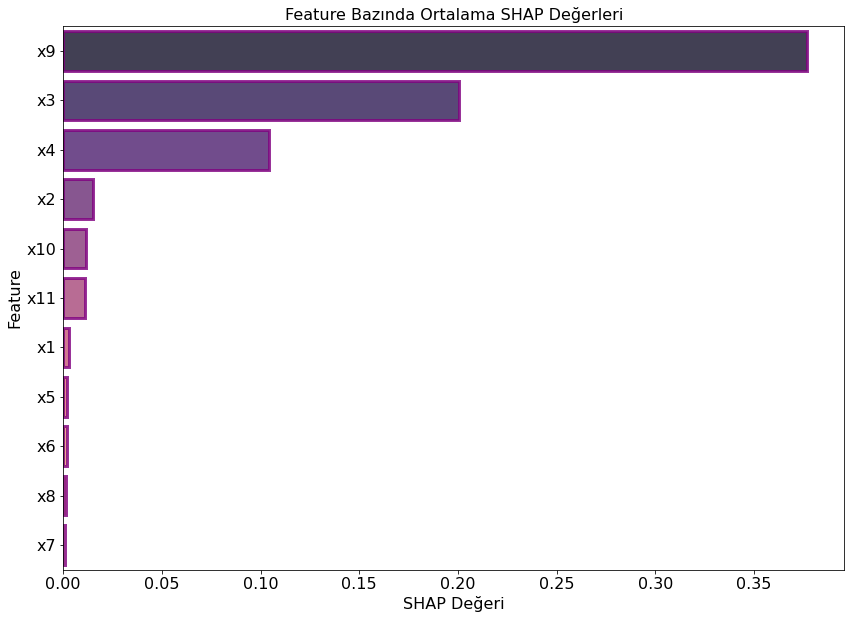

In [10]:
# Shap değerlerinin hesaplanması
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

# Mutlak içine alınıp ortalama değerlerin bulunması
shap_values_mean_abs = np.abs(shap_values).mean(axis=0)
shap_values_df = pd.DataFrame(shap_values_mean_abs,
                              columns=['importance'],
                              index=X_test.columns)

# büyükten küçüğe sırala
shap_values_df.sort_values('importance', 
                           ascending=False,
                           inplace=True)
plt.figure(figsize=(14, 10))

sns.barplot(x='importance',
            y=shap_values_df.index,
            data=shap_values_df,
            palette="magma", orient='h',
            **{'edgecolor': 'purple', 'linewidth': 3, 'alpha': 0.8})

plt.xlabel('SHAP Değeri', fontsize=16)
plt.ylabel('Feature', fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.title('Feature Bazında Ortalama SHAP Değerleri', fontsize=16)
plt.show()

#### Modelin tahminine en çok katkı x3 ve x9 özellikleri tarafından sağlanmış. Bu özellikler hedef ile lineer bir correlation içeriyordu. Sadece bu özellikleri alıp daha yakından inceleyelim.

Text(0.5, 1.0, 'Sadece X3 ve X9')

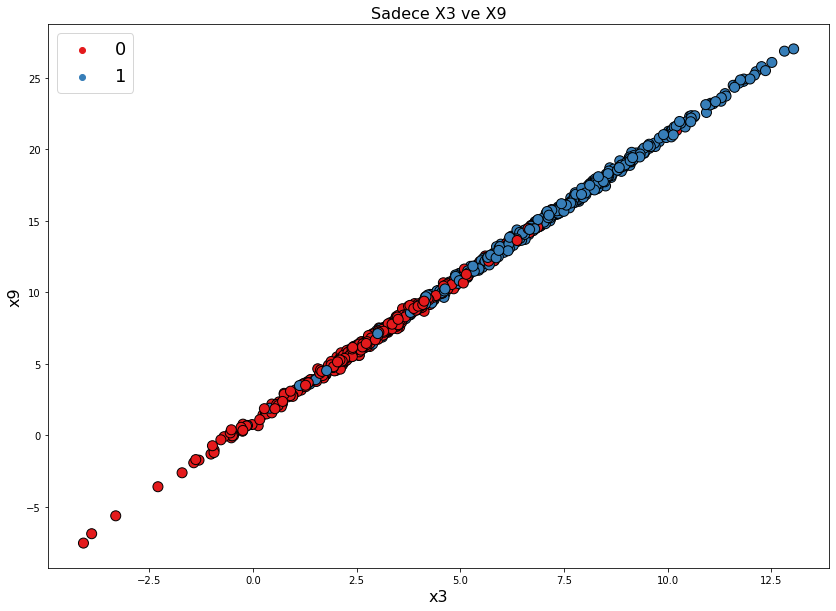

In [11]:
#  Sadece x9 ve x3 özelliklerini seçelim
subset_data = data[['x3', 'x9', 'labels']]

plt.figure(figsize=(14, 10))

# Data nasıl görünüyor?
sns.scatterplot(x='x3', y='x9', data=subset_data, palette='Set1', s=100,
                hue = 'labels', edgecolor='black', linewidth=1)
plt.legend(fontsize=18)
plt.xlabel('x3', fontsize=16)
plt.ylabel('x9', fontsize=16)
plt.title('Sadece X3 ve X9', fontsize=16)

### Burada güzel bir yorum var:
 * `df.corr()` yapılınca hedef ile yüksek katsayı gösteren özellikler, modelin işini kolaylaştırıyor. Neden mi? Dataseti daha lineer bir hale getirmiş oluyor. 
 
### Datasetin Lineer Olması Ne Demek?!
 * Burada classification yaptığımız için, datasetin lineer olması, lineer bir çizgi ile ayrılabileceğini göstermektedir.
 
### O zaman sadece X3 ve X9 yeterli olur mu?
 * Hayır, bu özellikler sadece modelin `predictive power`'ını artıracaktır. Yani modelin daha önce görmediği datada nasıl tepki vereceği gibi düşünebilirsiniz. Şimdi bu x3 ve x9'u drop edip etkisini görelim.

In [12]:
xgb_params = {
    'random_state': 42,
    'n_estimators': 500,
    'max_depth': 5,
    'learning_rate': 0.001,
    'gamma': 0.2,
    'min_child_weight': 2,
    'subsample': 0.9,
    'colsample_bytree': 0.9
}

of_params = {'random_state': 42,
             'n_estimators': 500,
             'max_depth': None}

def fit_xgb(X_train, y_train,
            X_test, y_test,
            overfit = False, 
            decision_boundary=False):
    if overfit:
        xgb = XGBClassifier(**of_params)
    else:
        xgb = XGBClassifier(**xgb_params)
    xgb.fit(X_train, y_train)

    print(f'F1 Score on training set: {f1_score(y_train, xgb.predict(X_train)):.4f}')
    print(f'F1 Score on test set: {f1_score(y_test, xgb.predict(X_test)):.4f}')

    # Feature Importance bakalım.
    feature_importance = pd.DataFrame({'feature': X_train.columns, 
                                       'importance': list(xgb.get_booster().get_score(importance_type='gain').values())})
    feature_importance.sort_values('importance', ascending=False, inplace=True, ignore_index=True)
    print(feature_importance)
    
    if decision_boundary:
        plot_decision_boundary(xgb, 
                               X_train.values, y_train.values,
                               X_test.values, y_test.values) 

In [13]:
X_train_subset = X_train[X_train.columns[~X_train.columns.isin(['x3','x9'])]]

X_test_subset = X_test[X_test.columns[~X_test.columns.isin(['x3','x9'])]]

# Aynı parametrelerle fit edelim
fit_xgb(X_train_subset, y_train,
        X_test_subset, y_test)

F1 Score on training set: 0.7515
F1 Score on test set: 0.6095
  feature  importance
0      x4       16.76
1      x6        5.06
2      x1        4.93
3      x8        4.92
4      x5        4.92
5     x11        4.91
6      x7        4.60
7      x2        4.28
8     x10        3.40


### Gözle görülür overfitting:
 * Modelin `predictive power`'ı düştüğü için overfitting gözlendi. Aslında, burada çok fazla bilgiyi verisetinden atmış olduk. Model train setinde de öncekinden çok düşük performans göstermiş oldu.

---

### Sadece X3 ve X9 ile performansa bakalım.

F1 Score on training set: 0.8982
F1 Score on test set: 0.8177
  feature  importance
0      x9       27.29
1      x3       26.03


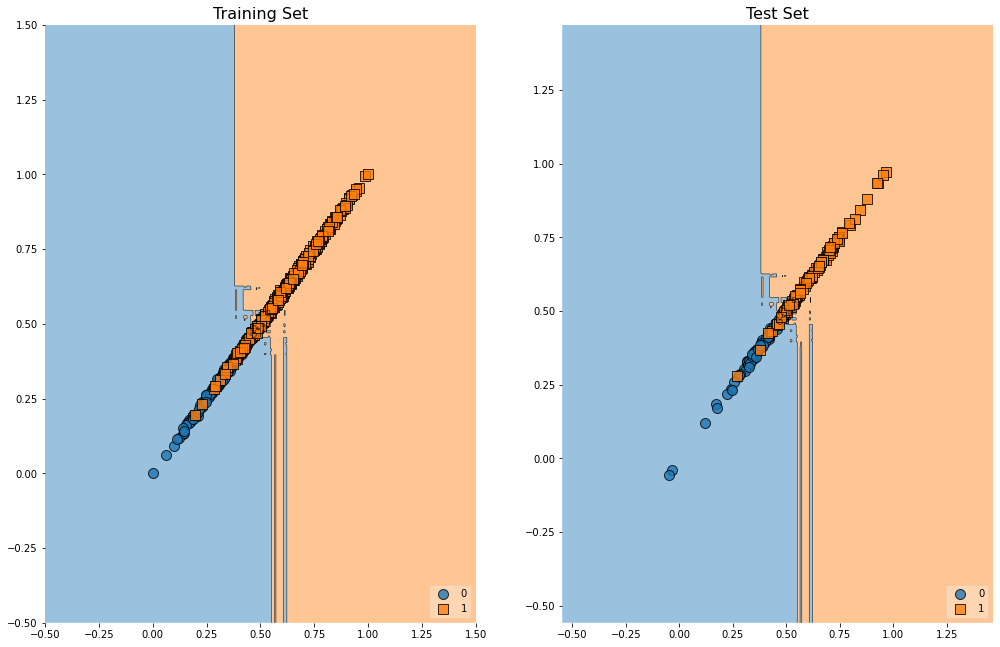

In [14]:
# Train ve test'i de subset olarak alalım
X_train_subset = X_train[['x3', 'x9']]
X_test_subset = X_test[['x3', 'x9']]

# Aynı parametrelerle fit edelim
fit_xgb(X_train_subset, y_train,
        X_test_subset, y_test, 
        decision_boundary=True)

#### Modelin genelleme yeteneğinde biraz kayıp gözlendi, overfit olmaya başladı. Demek ki diğer featurelar da genellemek için bilgi sağlıyormuş. Buradan modelin de complex oluşu önemli rol oynamaktadır.

#### Ağaç modelleri non-lineer modellel olduğu için decision boundary da non-lineer, cetvelle çizilmiş gibi.

### Logistic Regression kullansaydık sonuç:
 * Logistic Regression **lineer** bir modeldir. Train ve Test verisinde sırasıyla %85 ve %84 F1-Skoru verdi.

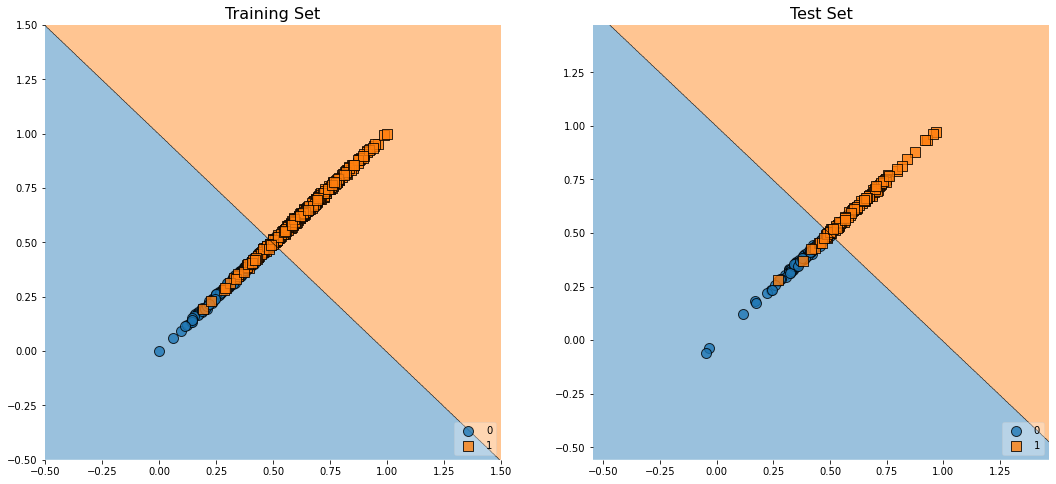

---

#### Tamamen overfitting olduğunda decision boundary aşağıdaki gibi görünecektir:
 * Buna ayrıca en son kısımda daha yakından bakıyor olacağız.

F1 Score on training set: 0.9975
F1 Score on test set: 0.8077
  feature  importance
0      x3        0.58
1      x9        0.33


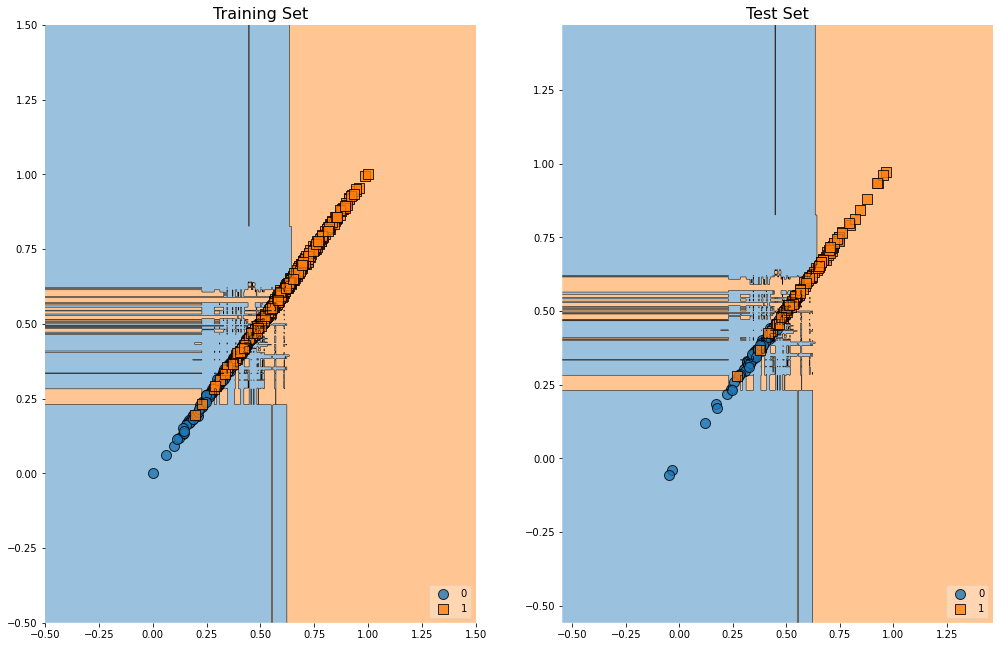

In [15]:
fit_xgb(X_train_subset, y_train,
        X_test_subset, y_test,
        overfit=True, 
        decision_boundary=True)

## Logistic Regression - Multicollinearity tarafından etkilenir

In [16]:
def fit_logit(X_train,
              y_train,
              X_test,
              y_test):

    logit_model = sm.Logit(y_train.values.reshape(-1, 1), X_train)
    result = logit_model.fit()

    print(f"Train F1 Skoru: {f1_score(y_train, result.predict(X_train) > 0.5):.4f}")
    print(f"Test F1 Skoru: {f1_score(y_test, result.predict(X_test) > 0.5):.4f}")

    print(result.summary())

In [17]:
fit_logit(X_train, y_train, X_test, y_test)

Optimization terminated successfully.
         Current function value: 0.353056
         Iterations 7
Train F1 Score: 0.8543
Test F1 Score: 0.8476
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  800
Model:                          Logit   Df Residuals:                      789
Method:                           MLE   Df Model:                           10
Date:                Fri, 24 Mar 2023   Pseudo R-squ.:                  0.4906
Time:                        00:34:36   Log-Likelihood:                -282.44
converged:                       True   LL-Null:                       -554.52
Covariance Type:            nonrobust   LLR p-value:                1.607e-110
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.3953      3.946      0.354      0.724      -6.

#### Görüldüğü üzere parametre katsayılarında çok büyük bir kesinsizlik mevcut, bu yorumlamayı zorlaştırır.
 * Burada modelin katsayılarının nasıl yorumlanır diye uzatmayacağım. Bakmamız gereken kısım %95'lik confidence interval (en sağda). Bir yorum yapmak istesek, mesela `x3`, -9.941 ile 59.689 arasında yer alıyormuş :O
 
--- 

### Nedir bu VIF (Variance Inflation Factor)?
 * VIF, bağımsız değişkenlerin çoklu doğrusal regresyon modelinde hangi ölçüde multicollinearity'e sahip olduğunu ölçen bir istatistiksel değerdir. 
 * Genelde 5'ten büyük değerler, problemsel sayılır. Bu projede 10'u sınır olarak kullanalım.

In [18]:
def get_vif(X):
    vif = pd.DataFrame()
    vif['Features'] = X.columns
    
    vif['VIF'] = [variance_inflation_factor(X.values, i) 
                  for i in range(X.shape[1])]

    vif.sort_values(by='VIF', ascending=False, inplace=True)
    
    return vif.reset_index(drop=True)

In [19]:
get_vif(X_train)

,Features,VIF
0,x3,8216.84
1,x9,8198.14
2,x1,407.88
3,x8,401.81
4,x7,9.00
5,x5,8.53
6,x2,8.24
7,x4,8.22
8,x6,6.83
9,x10,3.97


---

#### `x3`, `x9`, `x1`, ve `x8`'ü direkt olarak drop edersek ne olur?

In [20]:
fit_logit(X_train.drop(['x3', 'x9', 'x1', 'x8'], axis=1), 
          y_train, 
          X_test.drop(['x3', 'x9', 'x1', 'x8'], axis=1),
          y_test)

Optimization terminated successfully.
         Current function value: 0.689252
         Iterations 4
Train F1 Score: 0.5237
Test F1 Score: 0.4757
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  800
Model:                          Logit   Df Residuals:                      793
Method:                           MLE   Df Model:                            6
Date:                Fri, 24 Mar 2023   Pseudo R-squ.:                0.005615
Time:                        00:34:36   Log-Likelihood:                -551.40
converged:                       True   LL-Null:                       -554.52
Covariance Type:            nonrobust   LLR p-value:                    0.3982
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x2             0.3682      0.389      0.948      0.343      -0.

#### 0.52'lik F1-Score underfit olduğunu işaret ediyor diyebiliriz. VIF score'u yüksek olan her şeyi hemen drop etmemeliyiz.

---

#### Sadece X3'ü drop edip sonuca bakalım.

In [21]:
get_vif(X_train.drop('x3', axis=1))

,Features,VIF
0,x1,407.53
1,x8,401.50
2,x7,8.99
3,x9,8.63
4,x5,8.52
5,x2,8.22
6,x4,8.21
7,x6,6.83
8,x10,3.97
9,x11,3.80


In [22]:
fit_logit(X_train.drop('x3', axis=1), y_train,
          X_test.drop('x3', axis=1), y_test)

Optimization terminated successfully.
         Current function value: 0.354291
         Iterations 7
Train F1 Score: 0.8529
Test F1 Score: 0.8531
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  800
Model:                          Logit   Df Residuals:                      790
Method:                           MLE   Df Model:                            9
Date:                Fri, 24 Mar 2023   Pseudo R-squ.:                  0.4889
Time:                        00:34:36   Log-Likelihood:                -283.43
converged:                       True   LL-Null:                       -554.52
Covariance Type:            nonrobust   LLR p-value:                5.325e-111
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.3117      3.942      0.333      0.739      -6.

#### `X9`'un %95'lik confidence intervalina bakınca `13.83` ve `18.14` arasında yer aldığını görebiliriz. `X3`'u drop etmeden önce `-43.332` ve `25.854` arasındaydı. Listenin başında bulunan `X1`'i de drop edip bakalım:

In [23]:
get_vif(X_train.drop(['x1', 'x3'], axis=1))

,Features,VIF
0,x8,8.99
1,x7,8.93
2,x9,8.63
3,x5,8.47
4,x2,8.21
5,x4,8.17
6,x6,6.80
7,x10,3.97
8,x11,3.80


In [24]:
fit_logit(X_train.drop(['x1', 'x3'], axis=1), 
          y_train, 
          X_test.drop(['x1', 'x3'], axis=1),
          y_test)

Optimization terminated successfully.
         Current function value: 0.354360
         Iterations 7
Train F1 Score: 0.8519
Test F1 Score: 0.8476
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  800
Model:                          Logit   Df Residuals:                      791
Method:                           MLE   Df Model:                            8
Date:                Fri, 24 Mar 2023   Pseudo R-squ.:                  0.4888
Time:                        00:34:36   Log-Likelihood:                -283.49
converged:                       True   LL-Null:                       -554.52
Covariance Type:            nonrobust   LLR p-value:                6.610e-112
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x2            -0.9949      0.578     -1.720      0.085      -2.

#### Her katsayı için `std err` ideal görünüyor. Yani öncekilere göre tabikii :D

In [25]:
# Correlation içeren daha fazla feature ekleyelim.
data2 = data.copy()
data2['x12'] = data2['x1'] + data2['x2'] + np.random.normal(0, 0.5, data2.shape[0])
data2['x13'] = data2['x3'] + data2['x4'] + np.random.normal(0, 0.5, data2.shape[0])
data2['x14'] = data2['x5'] + data2['x6'] + np.random.normal(0, 0.5, data2.shape[0])

# labels column'unu sona at
cols_with_labels = data2.columns.tolist()
cols_with_labels.remove('labels')
cols_with_labels.append('labels')
data2 = data2.loc[:, cols_with_labels]

data2.dropna(inplace=True)

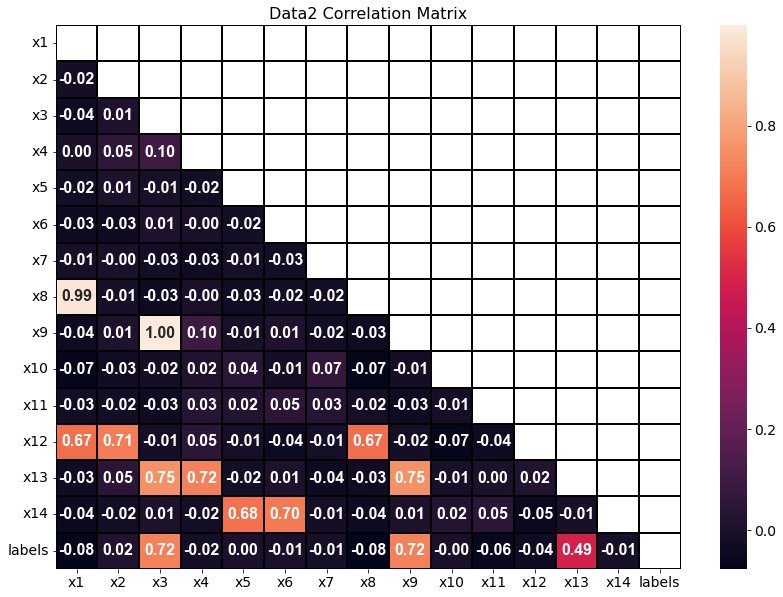

In [26]:
plot_corr(data2, "Data2 Correlation Matrix")

In [27]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(data2.drop('labels', axis=1),
                                                      data2['labels'],
                                                      test_size=0.2,
                                                      random_state=42)
scaler2 = Scaler()
X_train2 = scaler2.fit_transform(X_train2)
X_test2 = scaler2.transform(X_test2)

X_train2 = pd.DataFrame(X_train2, columns=data2.drop('labels', axis=1).columns)
X_test2 = pd.DataFrame(X_test2, columns=data2.drop('labels', axis=1).columns)

fit_logit(X_train2, y_train2, X_test2, y_test2)

Optimization terminated successfully.
         Current function value: 0.331538
         Iterations 7
Train F1 Score: 0.8700
Test F1 Score: 0.8679
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  800
Model:                          Logit   Df Residuals:                      786
Method:                           MLE   Df Model:                           13
Date:                Fri, 24 Mar 2023   Pseudo R-squ.:                  0.5217
Time:                        00:34:37   Log-Likelihood:                -265.23
converged:                       True   LL-Null:                       -554.52
Covariance Type:            nonrobust   LLR p-value:                2.829e-115
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -2.5188      4.657     -0.541      0.589     -11.

#### Confidence Intervaldeki çılgın aralıklar burada da mevcut, fakat overfitting YOK.

In [28]:
get_vif(X_train2)

,Features,VIF
0,x3,8672.81
1,x9,8254.62
2,x13,544.66
3,x1,529.26
4,x8,402.89
5,x12,354.03
6,x14,236.01
7,x4,188.09
8,x2,133.90
9,x5,118.67


In [29]:
get_vif(X_train2.drop(['x9', 'x14', 'x13', 'x12', 'x8'], axis=1))

,Features,VIF
0,x1,9.13
1,x7,8.96
2,x3,8.65
3,x5,8.50
4,x2,8.20
5,x4,8.20
6,x6,6.78
7,x10,3.97
8,x11,3.80


#### VIF değerleri 10'un altına düşene kadar belli feature'ları dropladık

In [30]:
fit_logit(X_train2.drop(['x9', 'x14', 'x13', 'x12', 'x8'], axis=1), y_train2,
          X_test2.drop(['x9', 'x14', 'x13', 'x12', 'x8'], axis=1), y_test2)

Optimization terminated successfully.
         Current function value: 0.353932
         Iterations 7
Train F1 Score: 0.8511
Test F1 Score: 0.8531
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  800
Model:                          Logit   Df Residuals:                      791
Method:                           MLE   Df Model:                            8
Date:                Fri, 24 Mar 2023   Pseudo R-squ.:                  0.4894
Time:                        00:34:37   Log-Likelihood:                -283.15
converged:                       True   LL-Null:                       -554.52
Covariance Type:            nonrobust   LLR p-value:                4.709e-112
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -2.8239      0.606     -4.661      0.000      -4.

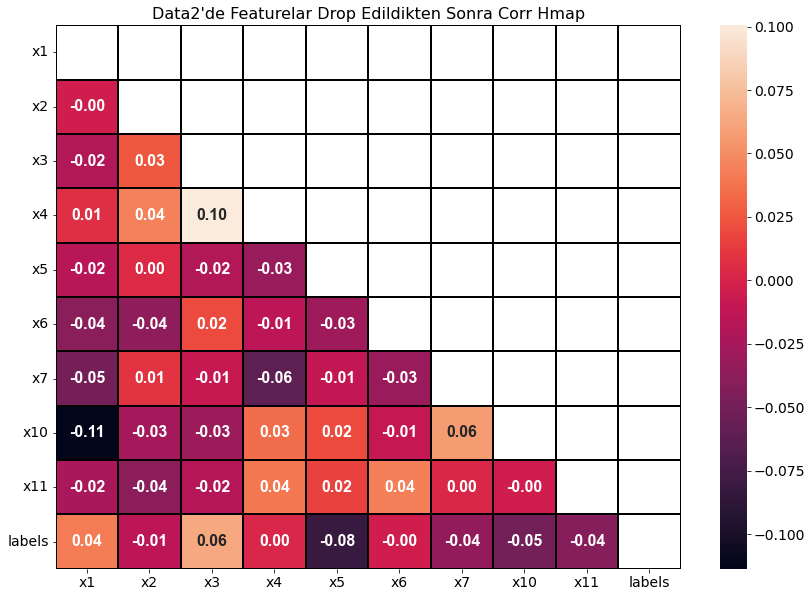

In [31]:
plot_corr(pd.concat([X_train2.drop(['x9', 'x14', 'x13', 'x12', 'x8'], axis=1), y_train2], axis=1),
          "Data2'de Featurelar Drop Edildikten Sonra Corr Hmap")

### Hedef değişken ile çok yüksek correlation içeren feature olursa?

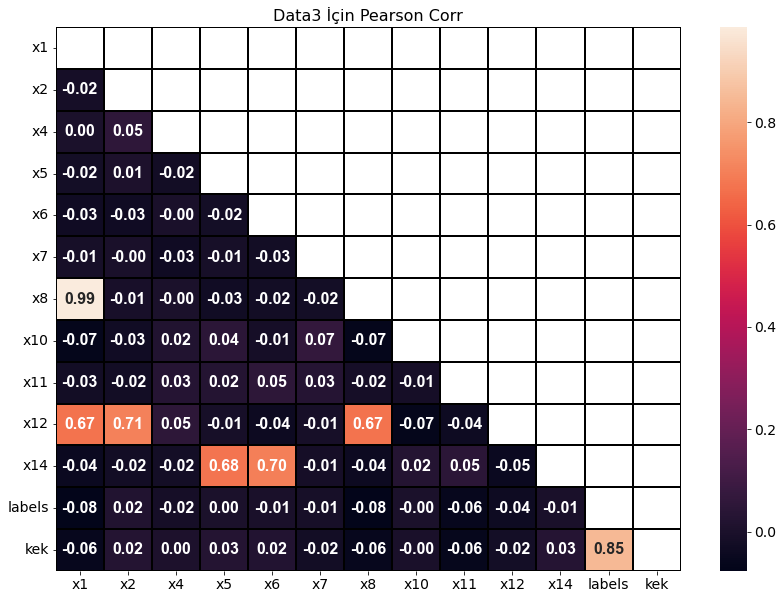

In [32]:
data3 = data2.copy()
data3.drop(["x3", "x9", "x13"], axis=1, inplace=True)

# Labellarla direkt olarak yüksek lineer correlation bir feature 
# oluşturalım. Bu feature'ın ismi "kek" olsun
data3["kek"] = data3["labels"] + np.random.normal(0.5, 0.3, data3.shape[0]) + 10

plot_corr(data3, "Data3 İçin Pearson Corr")

In [33]:
data3

,x1,x2,x4,x5,x6,x7,x8,x10,x11,x12,x14,labels,kek
0,3.85,7.05,4.73,4.62,5.09,4.71,6.05,1.06,0.56,10.47,9.15,0,10.74
1,4.23,10.28,7.04,5.60,4.28,3.86,6.83,-0.80,0.33,14.49,9.57,1,10.97
2,4.51,8.13,2.39,4.45,3.15,1.59,5.85,1.04,-1.07,12.65,7.13,0,10.71
3,1.71,3.34,2.05,4.79,1.80,7.98,2.28,0.09,0.14,5.29,6.32,0,10.43
4,5.40,6.22,7.20,1.89,4.56,2.64,7.54,-0.63,0.52,10.94,6.34,0,10.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,6.43,6.46,3.91,6.08,7.51,2.53,10.59,-0.59,-0.74,12.87,13.44,0,11.16
996,4.18,3.81,2.12,0.22,7.46,5.76,6.98,-0.95,-0.36,8.34,8.06,1,11.60
997,8.22,6.96,6.42,2.26,3.58,3.77,12.43,-1.05,-0.33,16.73,5.57,1,11.25
998,4.64,6.85,7.38,4.82,2.62,5.07,7.00,0.37,-0.90,11.90,7.43,0,11.00


In [34]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(data3.drop(['labels'], axis=1),
                                                      data3['labels'],
                                                      test_size=0.2,
                                                      random_state=42)

fit_xgb(X_train2, y_train2, X_test2, y_test2)

F1 Score on training set: 0.9671
F1 Score on test set: 0.9500
   feature  importance
0      kek      123.74
1       x4        8.63
2      x11        4.34
3      x12        3.69
4       x5        3.25
5       x1        3.18
6       x8        3.16
7       x6        3.13
8       x7        2.96
9      x14        2.96
10      x2        2.59
11     x10        1.85


#### Görüldüğü üzere overfitting olmamıştır, sadece yorumlamayı zorlaştırmıştır.
 * Çünkü hiçbir regularization tekniği vb. uygulamadık. Burada en çok bilgi veren yani sınıflandırmayı büyük ölçüde kolaylaştıran bir özellik var, bunun sonucunda diğer özelliklerin önemi git gide düşmüş oldu. 
 
 
 * Test ortamında da aynı bu şekilde özellikler ve data gelecekse ve bu `kek` değişkeni ile benzer özelliklere sahip bir özellik olacaksa (hedefle yüksek correlation içerme), modelin tahminleri etkilenmeyecektir.

## Lineer Olmayan Datada Sınıflandırma

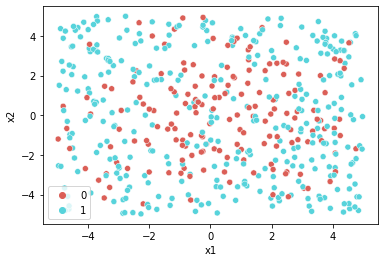

In [35]:
non_linear_x = np.random.rand(n_samples // 2, 2) * 10 - 5
non_linear_y = np.where(np.sum(non_linear_x**2 + np.random.normal(0.5, 10.3, non_linear_x.shape),
                               axis=1) > 10, 1, 0)

data4 = pd.DataFrame(non_linear_x, columns=['x1', 'x2'])
data4['label'] = non_linear_y

sns.scatterplot(data=data4, x="x1", y="x2", hue=non_linear_y, 
                palette=sns.color_palette("hls", 2))
plt.show()

#### Correlation'ın düşük çıkması featurelar ve inputlar arasında ilişki olmadığını göstermez. Correlation terimi aksi belirtilmedikçe lineer olarak katsayı belirtir. 

#### Featurelar ve inputlar arasında bir ilişki olmazsa, yani veri random olursa modeller zaten öğrenemez.

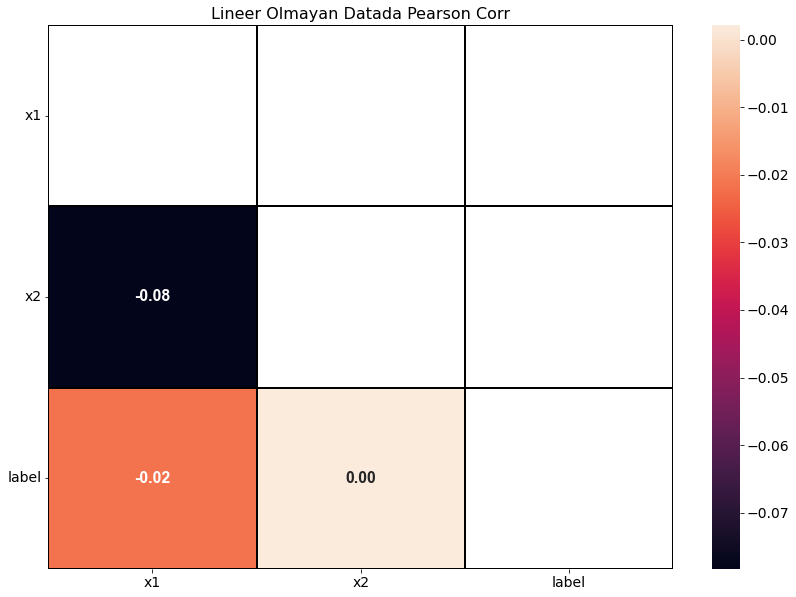

In [36]:
plot_corr(data4, "Lineer Olmayan Datada Pearson Corr")

F1 Score on training set: 0.8419
F1 Score on test set: 0.7871
  feature  importance
0      x2        4.19
1      x1        3.80


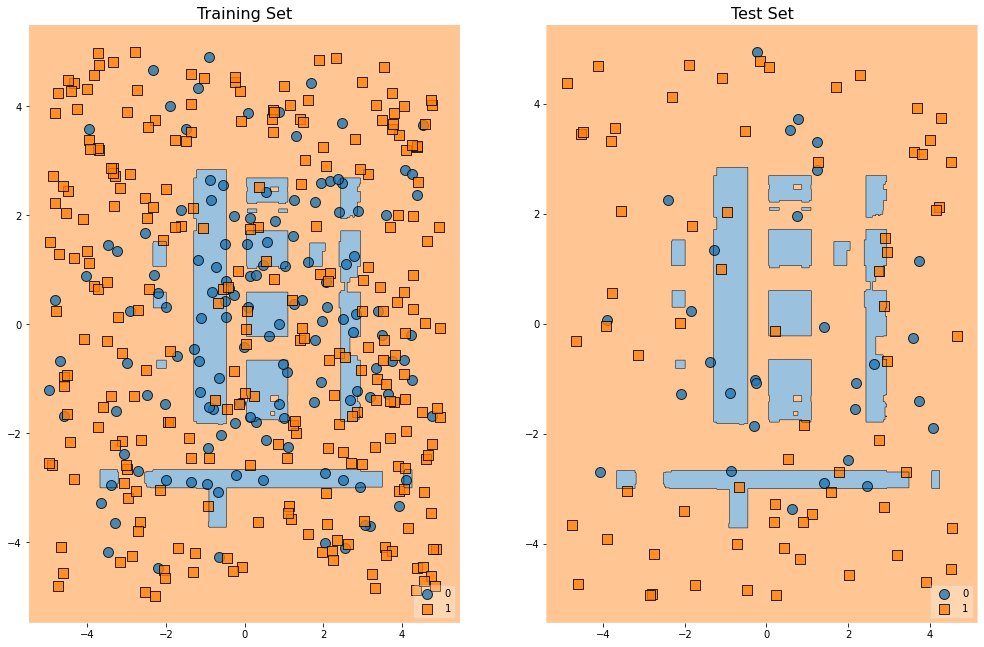

In [37]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(data4.drop('label', axis=1),
                                                      data4['label'],
                                                      test_size=0.2,
                                                      random_state=42)
fit_xgb(X_train4, y_train4, X_test4, y_test4,
       decision_boundary=True)

### Overfiti Yakından Görelim

Her training örneği için bir alan oluşmuş oldu, yani model high variance'a sahiptir.

F1 Score on training set: 1.0000
F1 Score on test set: 0.7376
  feature  importance
0      x2        0.18
1      x1        0.18


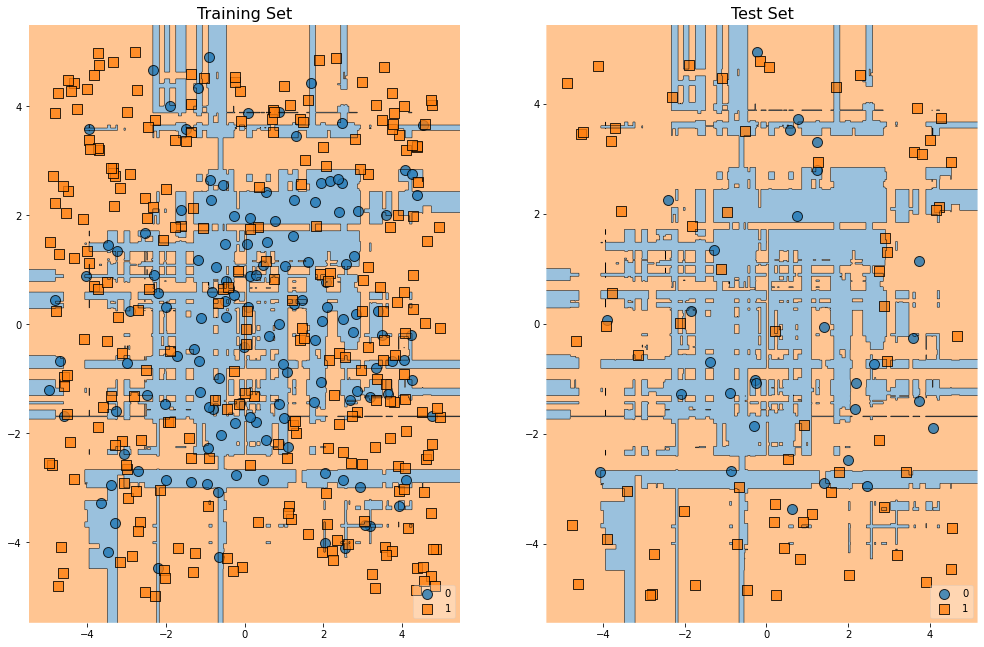

In [38]:
fit_xgb(X_train4, y_train4, X_test4, y_test4,
        overfit=True,
        decision_boundary=True)